<a href="https://colab.research.google.com/github/achmadbauravindah/TextClassifiaction-SVM-TitanicDataset/blob/main/Classification_SVM_TitanicDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt # Plotting
import numpy as np # Array
import pandas as pd # Dataframe
from sklearn.impute import KNNImputer # Missing Value
from sklearn.preprocessing import MinMaxScaler # Normalisasi data
from sklearn.svm import SVC # Support Vector Machine Classifier
from sklearn.model_selection import train_test_split # Split data
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import time
import random
import csv

In [ ]:
# Get data from Kaggle
_ = ! git clone https://github.com/achmadbauravindah/ravin_kaggle_credential.git # get credential from kaggle
_ = ! pip install kaggle # install kaggle on device
_ = ! mkdir ~/.kaggle # make hidden folder .kaggle to configure credential
_ = ! cp ravin_kaggle_credential/kaggle.json ~/.kaggle/ # copy credential from github to .kaggle folder
_ = ! chmod 600 ~/.kaggle/kaggle.json # change access
_ = ! kaggle datasets download titanic-dataset # which dataset to download
_ = ! unzip titanic-dataset # unzip if data zipped

In [ ]:
# Load dataset from storage
PATH = "Titanic Dataset.csv"
raw_data = pd.read_csv(PATH, delimiter=';')

In [ ]:
raw_data.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [ ]:
raw_data.shape

(1309, 12)

In [ ]:
def dropColumns(data):
  data = data.drop(['PassengerId'], axis=1) # Karena tidak ada korelasi dengan data
  data = data.drop(['Name'], axis=1) # Karena tidak ada korelasi dengan data
  data = data.drop(['Ticket'], axis=1) # Karena tidak ada korelasi dengan data
  data = data.drop(['Cabin'], axis=1) # Karena values banyak yang missing
  return data

In [ ]:
def encodingData(data): # Encode / Merubah Kategorikal menjadi Numerikal
  data['Sex'].replace({ 'male':0, 'female':1}, inplace=True)
  data['Embarked'].replace({ 'C':0, 'Q':1, 'S':2}, inplace=True)
  return data

In [ ]:
def handleMissingValues(data):
  k = 5
  imputer = KNNImputer(n_neighbors=k)
  data = pd.DataFrame(imputer.fit_transform(data), columns = data.columns)
  return data

In [ ]:
def normalizeData(data):
  data = np.array(data) # Ubah ke Numpy
  data = np.rint(data) # Membulatkan data
  data = pd.DataFrame(data) # Ubah ke Pandas
  scaler = MinMaxScaler()
  data = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
  return data

In [ ]:
def sliceLabel(data):
  X = data
  y = data.pop(0)
  return X, y

In [ ]:
def toNumpy(X, y):
  X = np.array(X)
  y = np.array(y)
  return X, y

In [ ]:
def parameters_tuning_SVM(model, X, y):
  params_grid_SVC = [
                  {'C': [0.5, 1, 10, 100],
                   'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
                   'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
                  ]
  optimal_parameters = GridSearchCV(estimator = model, 
                                  param_grid = params_grid_SVC, 
                                  cv=2, 
                                  scoring='accuracy'
                                  )
  optimum = optimal_parameters.fit(X, y)
  print(optimum.best_params_)

In [ ]:
titanic_data = raw_data
titanic_data = dropColumns(titanic_data)
titanic_data = encodingData(titanic_data)
titanic_data = handleMissingValues(titanic_data)
titanic_data = normalizeData(titanic_data)
X, y = sliceLabel(titanic_data) # Memisahkan data input dengan data label
X, y = toNumpy(X ,y) # Mengubah data ke bentuk array numpy

In [ ]:
# Parameters Tuning
SVCOpt = SVC()
parameters_tuning_SVM(SVCOpt, X, y)

{'C': 10, 'gamma': 0.1, 'kernel': 'poly'}


In [ ]:
def getMetrics(y_test_actual, y_test_predict):
  cm = confusion_matrix(y_test_actual, y_test_predict)
  accuracy = accuracy_score(y_test_actual, y_test_predict)
  recall = recall_score(y_test_actual, y_test_predict, average='macro')
  precision = precision_score(y_test_actual, y_test_predict, average='macro')
  f1 = f1_score(y_test_actual, y_test_predict, average='macro')
  return cm, accuracy*100, precision*100, recall*100, f1*100

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

def trainModelWithKFlod(n_folds, model, X, y):
  kfold = KFold(n_splits=n_folds, shuffle=True)

  # Simpan Metrics tiap fold
  acc_per_fold = []
  cm_per_fold = []
  precision_per_fold = []
  recall_per_fold =[]
  f1_per_fold = []

  for train_i, test_i in kfold.split(X, y):
    X_train = X[train_i]
    y_train = y[train_i]
    X_test = X[test_i]
    y_test = y[test_i]
    
    model.fit(X_train, y_train)
    y_test_predicted = model.predict(X_test)
    cm, accuracy, precision, recall, f1 = getMetrics(y_test, y_test_predicted)

    cm_per_fold.append(cm)
    acc_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)
  return acc_per_fold, cm_per_fold, precision_per_fold, recall_per_fold, f1_per_fold

In [ ]:
def ploting(cm_per_fold, 
            acc_per_fold, 
            precision_per_fold, 
            recall_per_fold, 
            f1_per_fold
            ):                    
  index = 0
  for cm in cm_per_fold:
    acc = acc_per_fold[index]
    precision = precision_per_fold[index]
    recall = recall_per_fold[index]
    f1 = f1_per_fold[index]
    print('------------------------------------------------------------------------')
    print(f'> Fold {index+1} - Accuracy: {acc}%')
    # Show Precision
    print('Precision: {:.2f}%'.format(precision))
    # Show Recall
    print('Recall: {:.2f}%'.format(recall))
    # Show F1Score
    print('F1 Score: {:.2f}%'.format(f1))
    # Show Confusion Matrix
    fig, ax = plt.subplots(figsize=(3, 3), constrained_layout="True")
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')        
    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title('Confusion Matrix', fontsize=12)
    plt.show()
    index+=1
  print('------------------------------------------------------------------------')
  print("RATA-RATA SEMUA 'METRICS' UNTUK SEMUA FOLD:")
  print(f'> Accuracy: {np.mean(acc_per_fold)}')
  print(f'> Precision: {np.mean(precision_per_fold)}%')
  print(f'> Recall: {np.mean(recall_per_fold)}%')
  print(f'> F1Score: {np.mean(f1_per_fold)}%')

  print('------------------------------------------------------------------------')

In [ ]:
def showAccuracyPlotFold(accuracy, epoch_time):
  foldKeN = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
  Akurasi = accuracy

  fig, ax = plt.subplots()
  ax.plot(foldKeN, Akurasi)

  ax.set(xlabel='Fold - n', ylabel='Akurasi (%)',
        title= 'Hasil Akurasi Epoch = 25 ({:.2f} s)'.format(epoch_time))
  ax.grid()
  
  plt.show()

In [ ]:
# Model dengan parameter terbaik
BestModelSVC = SVC(C=0.5, gamma='scale', kernel='rbf', random_state=42)

------------------------------------------------------------------------
> Fold 1 - Accuracy: 85.49618320610686%
Precision: 86.76%
Recall: 82.79%
F1 Score: 84.00%


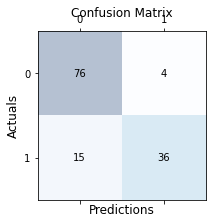

------------------------------------------------------------------------
> Fold 2 - Accuracy: 87.02290076335878%
Precision: 86.94%
Recall: 86.30%
F1 Score: 86.57%


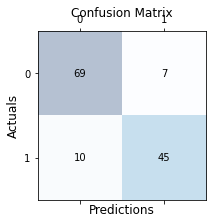

------------------------------------------------------------------------
> Fold 3 - Accuracy: 87.78625954198473%
Precision: 87.52%
Recall: 86.14%
F1 Score: 86.73%


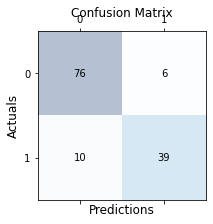

------------------------------------------------------------------------
> Fold 4 - Accuracy: 83.96946564885496%
Precision: 84.08%
Recall: 82.11%
F1 Score: 82.81%


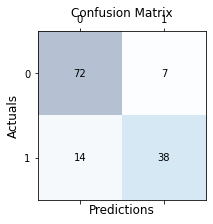

------------------------------------------------------------------------
> Fold 5 - Accuracy: 87.78625954198473%
Precision: 87.60%
Recall: 86.30%
F1 Score: 86.85%


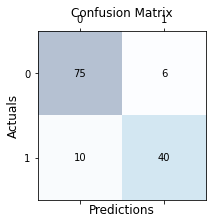

------------------------------------------------------------------------
> Fold 6 - Accuracy: 85.49618320610686%
Precision: 85.21%
Recall: 84.49%
F1 Score: 84.80%


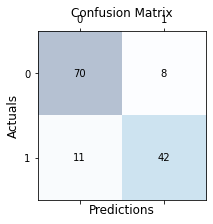

------------------------------------------------------------------------
> Fold 7 - Accuracy: 87.78625954198473%
Precision: 86.55%
Recall: 87.20%
F1 Score: 86.85%


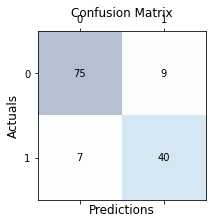

------------------------------------------------------------------------
> Fold 8 - Accuracy: 84.7328244274809%
Precision: 83.95%
Recall: 83.95%
F1 Score: 83.95%


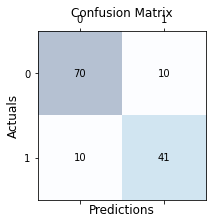

------------------------------------------------------------------------
> Fold 9 - Accuracy: 77.86259541984732%
Precision: 75.38%
Recall: 73.79%
F1 Score: 74.43%


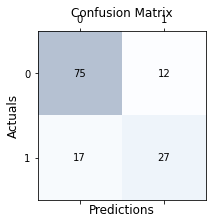

------------------------------------------------------------------------
> Fold 10 - Accuracy: 87.6923076923077%
Precision: 86.25%
Recall: 85.31%
F1 Score: 85.75%


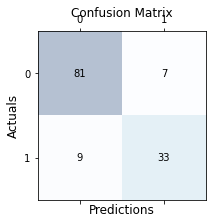

------------------------------------------------------------------------
RATA-RATA SEMUA 'METRICS' UNTUK SEMUA FOLD:
> Accuracy: 85.56312389900178
> Precision: 85.0226576718143%
> Recall: 83.83699767291004%
> F1Score: 84.2737962160974%
------------------------------------------------------------------------


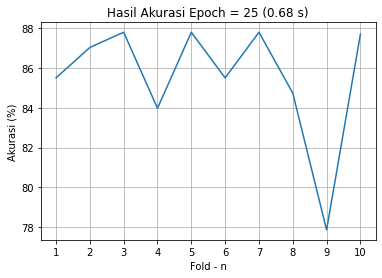

Waktu Komputasi SVM (0.68 s)


In [ ]:
# Model SVM
# n_folds = 5,
start = time.process_time()
acc_per_fold, cm_per_fold, precision_per_fold, recall_per_fold, f1_per_fold = trainModelWithKFlod(10, BestModelSVC, X, y)
epoch_time = time.process_time() - start

ploting(cm_per_fold, 
        acc_per_fold, 
        precision_per_fold, 
        recall_per_fold, 
        f1_per_fold
        )
showAccuracyPlotFold(acc_per_fold, epoch_time)
print('Waktu Komputasi SVM ({:.2f} s)'.format(epoch_time))